#### Picture of Philadelphia 

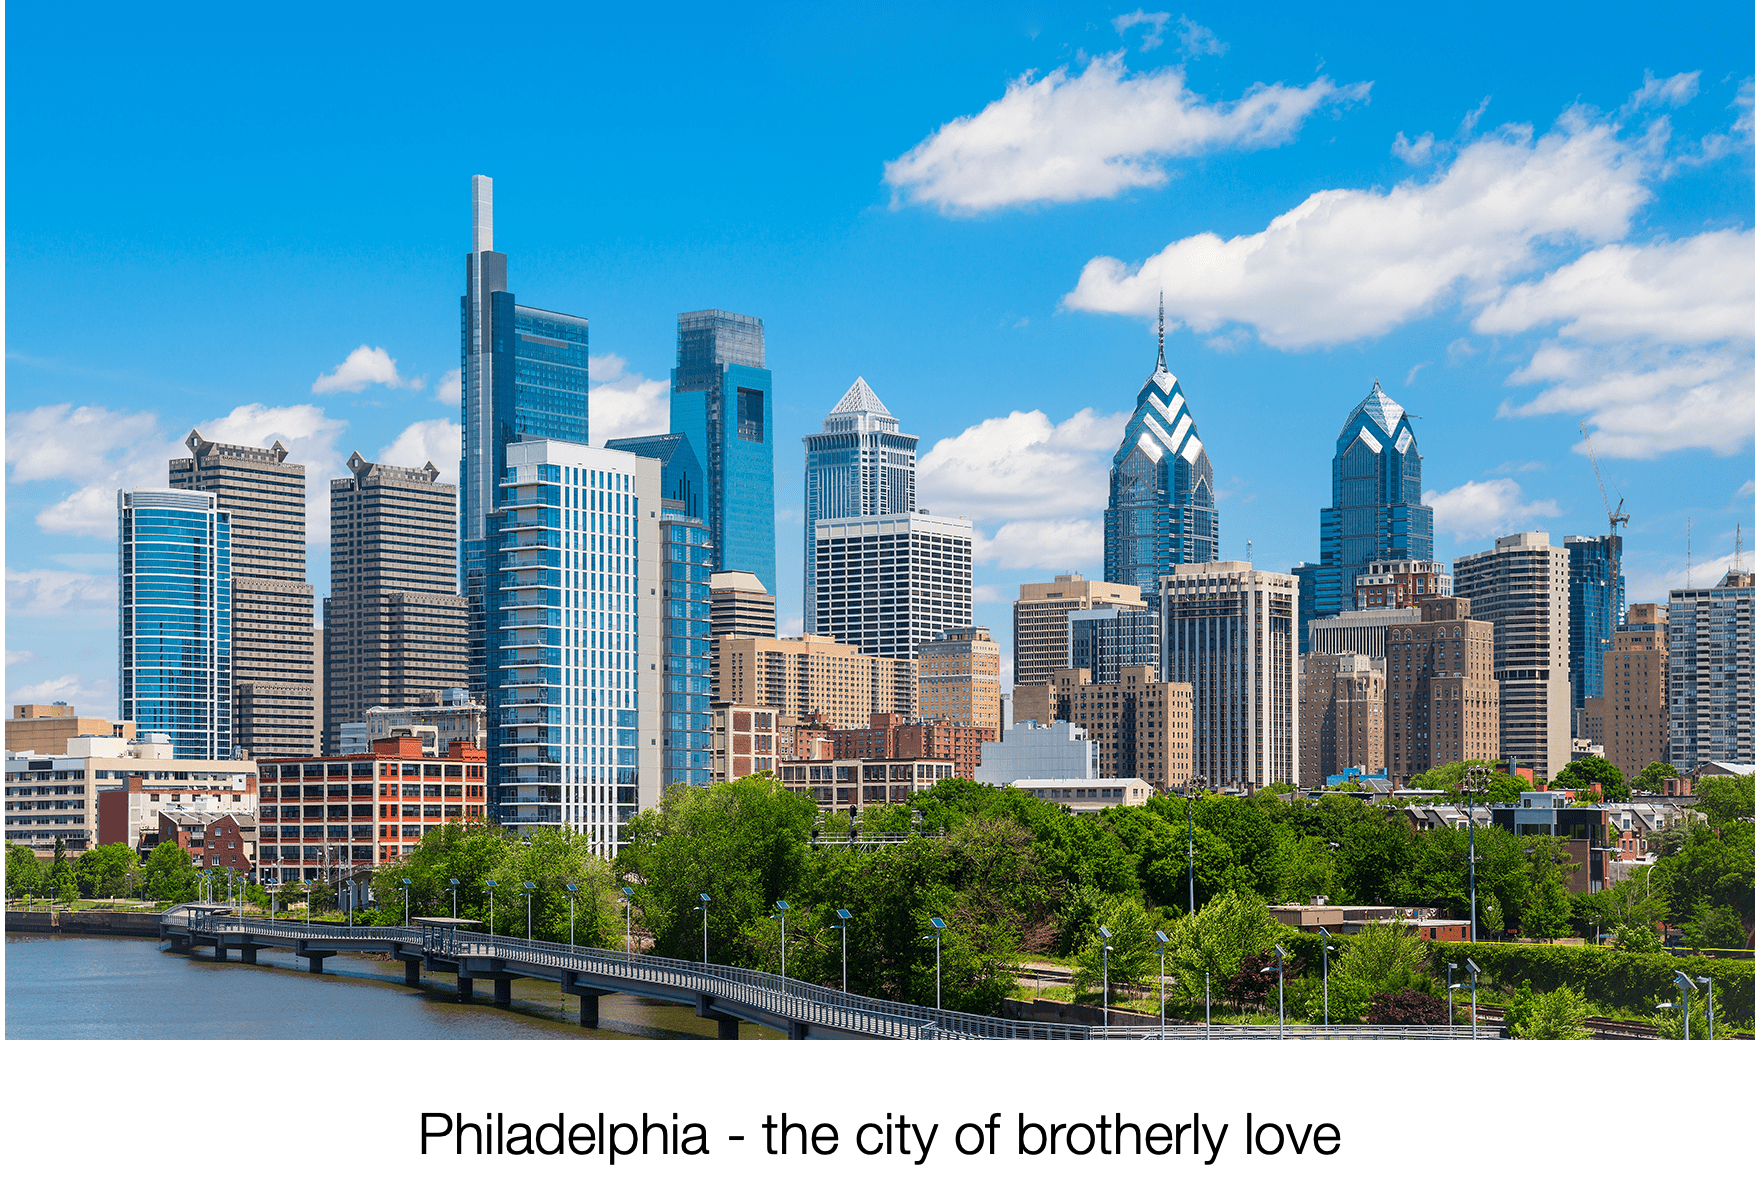

# 1. Background
Philadelphia is the sixth largest city in the United States with an estimated population of over 1.5 million people. Extending the boundaries to Philadelphia county which are easily accessible by Amtrak and other public transportation, the city has over 6 million residents. There are many large corporations including Comcast, Aramark, and Urban outfitters. These alone account for over \\$100 billion worth of yearly revenue, with an estimated gross metropolitan product (GMP) just shy of \\$500 billion. The city also hosts a diverse racial make- up and multiple well respected universities.

The most recent median income (2013) for Philadelphia was \\$36,836, which his relatively lower than the median income for metropolitan areas at \\$60,482. These incomes range from a high of \\$93,720 to a low of \\$14,185. [1]

# 2. Description of the business problem

My client is already a proud owner of two coffee shops, two eateries, a bakery, and a large family restaurant. He is looking to expand his business, particularly in the field of boutique coffee shops. However, he’s not exactly sure where the new coffee shop should be located. He has already had great success with a coffee shop located near a university, and would like to expand a bit beyond university clientele. He wants to make sure that his coffee shop is not overcrowded by other chain coffeeshops, i.e. Starbucks, or eateries that would take away his revenue, but this is not a. He is based in Pennsylvania and would like to continue to build his business in that area. He is very interested in the Philadelphia market and would like to know more details about where a new coffeeshop would bring in additional revenue for his business, while also expanding beyond university-centralized locations. 

This is a preliminary search. There are a few spots in the city that my client has already chosen as possible places to set up a new coffee shop, but he wants to see data that will help guide his decision. This would be initial research, and if the data yields a neighborhood that he is unsure of (extraneous factors like shop rent prices, crime, etc.) further analysis will have to be conducted. 

I plan to do a few things. 
- Explore Philadelphia Zipcodes/Neighborhoods using metrics including but not limited to…
    - population size
    - population density
    - average income
- Identify the most common venues in each Zip/Neighborhood to help make a location decision that could have an impact and immediate influence on the business. 
    

First, let's import the necessary libraries we'll need. 

In [66]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import simplejson as json
import seaborn as sns

from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

# 3. Description of the Data
- Postal Codes - I was able to download a file from https://www.geonames.org/postal-codes/US/PA/101/philadelphia.html that listed all the postal codes in Philadelphia City. I was also able to web scrape some population data for each postal code from http://zipatlas.com/us/pa/philadelphia/zip-code-comparison/population-density.htm. I’ve already put some of the data together, but will try to include an average salary for each zip code. 

- Income Data - http://zipatlas.com/us/pa/philadelphia/zip-code-comparison/population-density.htm. This is the income data that I used to merge with the population density data. 

- Foursquare API - I will use the Foursquare API to get the most common venues in Philadelphia, and connect them to the postal code data. 

- Starbucks Data -  I was able to download a CSV file for the Starbucks store locations from www.kaggle.com. I’ll use this information to display on a map of possible competitive stores to cross reference my own data. 

# 4. Data Cleaning

In [2]:
# population density url
url_density = 'http://zipatlas.com/us/pa/philadelphia/zip-code-comparison/population-density.htm'

data  = requests.get(url_density).text
soup = BeautifulSoup(data,"html5lib")
tables = soup.find_all('table') # in html table is represented by the tag <table>

I'm going to show the length of the tables, but since there was no id marker in the HTML, I had to manually search through the data to get what I wanted. 

In [3]:
print(len(tables))

# print(tables[13].prettify())  # <-- this is the table we want, but it's a lot

18


Now let's get that data from these tables.
 - First - set up an empty DataFrame with all the info that I want
 - Second - iterate through the table to find all the <code> tr </code> tags, and go again to get the <code> td </code> tags
 - Third - save the data into the appropriate columns and be sure to strip any unnecessary spaces

In [4]:
philly_data = pd.DataFrame(columns=["Number", "Zipcode", "Location", "City", "Population", "Density"])

for row in tables[13].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        number = col[0].text.strip()
        zipcode = col[1].text.strip()
        location = col[2].text.strip()
        city = col[3].text.strip()
        population = col[4].text.strip()
        density = col[5].text.strip()
        philly_data = philly_data.append({"Number":number, "Zipcode":zipcode, "Location":location, "City":city, "Population":population, "Density":density}, ignore_index=True)

philly_data.head()

Number   Zipcode               Location                        City  \
0      #  Zip Code               Location                        City   
1     1.     19103  39.952795, -75.173949  Philadelphia, Pennsylvania   
2     2.     19139  39.961529, -75.230259  Philadelphia, Pennsylvania   
3     3.     19107  39.951623, -75.158637  Philadelphia, Pennsylvania   
4     4.     19102  39.953423, -75.165384  Philadelphia, Pennsylvania   

   Population            Density  
0  Population  People / Sq. Mile  
1      19,714          29,353.79  
2      43,866          24,062.66  
3      12,340          22,723.74  
4       4,396          22,186.08

Looks okay, let's drop of that first row since those are the names of our columns, and we'll also drop the <code> Number </code> column since I don't know what that means. Then we'll set the datat to make sure the Zipcodes are all in order. 

In [5]:
philly_data.drop(0, axis=0, inplace=True)
philly_data.drop(['Number'], axis = 1, inplace=True)

In [6]:
philly_data.head()

Zipcode               Location                        City Population  \
1   19103  39.952795, -75.173949  Philadelphia, Pennsylvania     19,714   
2   19139  39.961529, -75.230259  Philadelphia, Pennsylvania     43,866   
3   19107  39.951623, -75.158637  Philadelphia, Pennsylvania     12,340   
4   19102  39.953423, -75.165384  Philadelphia, Pennsylvania      4,396   
5   19104  39.960323, -75.197883  Philadelphia, Pennsylvania     50,125   

     Density  
1  29,353.79  
2  24,062.66  
3  22,723.74  
4  22,186.08  
5  16,806.34

Looking good, we've got the Total Population, and the Population Density. We'll come back to this later. Now lets get the average incomes of the Zipcodes.

### Average Incomes for the Zip Codes
 - We'll do the same thing as before. No need to go into detail here. 

In [7]:
# income url
url_income = "http://zipatlas.com/us/pa/philadelphia/zip-code-comparison/median-household-income.htm"

data  = requests.get(url_income).text
soup = BeautifulSoup(data,"html5lib")
tables = soup.find_all('table')

In [8]:
income_data = pd.DataFrame(columns=["Number", "Zipcode", "Location", "City", "Population", "Avg Income"])

for row in tables[13].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        number = col[0].text.strip()
        zipcode = col[1].text.strip()
        location = col[2].text.strip()
        city = col[3].text.strip()
        population = col[4].text.strip()
        income = col[5].text.strip()
        income_data = income_data.append({"Number":number, "Zipcode":zipcode, "Location":location, "City":city, "Population":population, "Avg Income":income}, ignore_index=True)

income_data.head()

Number   Zipcode               Location                        City  \
0      #  Zip Code               Location                        City   
1     1.     19113  39.870679, -75.247782  Philadelphia, Pennsylvania   
2     2.     19106  39.950472, -75.147231  Philadelphia, Pennsylvania   
3     3.     19118  40.072443, -75.212415  Philadelphia, Pennsylvania   
4     4.     19154  40.095521, -74.981818  Philadelphia, Pennsylvania   

   Population          Avg Income  
0  Population  Avg. Income/H/hold  
1         136          $70,833.00  
2       8,359          $61,720.00  
3       9,608          $60,179.00  
4      35,606          $51,949.00

In [9]:
income_data.drop("Number", axis=1, inplace=True)
income_data.drop(0, axis=0, inplace=True)
income_data.sort_values('Zipcode', inplace=True)

In [10]:
income_data.head(10)

Zipcode               Location                        City Population  \
20   19102  39.953423, -75.165384  Philadelphia, Pennsylvania      4,396   
14   19103  39.952795, -75.173949  Philadelphia, Pennsylvania     19,714   
45   19104  39.960323, -75.197883  Philadelphia, Pennsylvania     50,125   
2    19106  39.950472, -75.147231  Philadelphia, Pennsylvania      8,359   
38   19107  39.951623, -75.158637  Philadelphia, Pennsylvania     12,340   
49   19108  39.959626, -75.160879  Philadelphia, Pennsylvania          0   
13   19111  40.063318, -75.077631  Philadelphia, Pennsylvania     58,874   
48   19112  39.893156, -75.168944  Philadelphia, Pennsylvania         29   
1    19113  39.870679, -75.247782  Philadelphia, Pennsylvania        136   
10   19114  40.069361, -75.000264  Philadelphia, Pennsylvania     31,083   

    Avg Income  
20  $35,625.00  
14  $37,959.00  
45  $16,151.00  
2   $61,720.00  
38  $24,448.00  
49       $0.00  
13  $37,996.00  
48       $0.00  
1   $70,833.00  
10  $41,592.00

#### Picture here of Google Maps
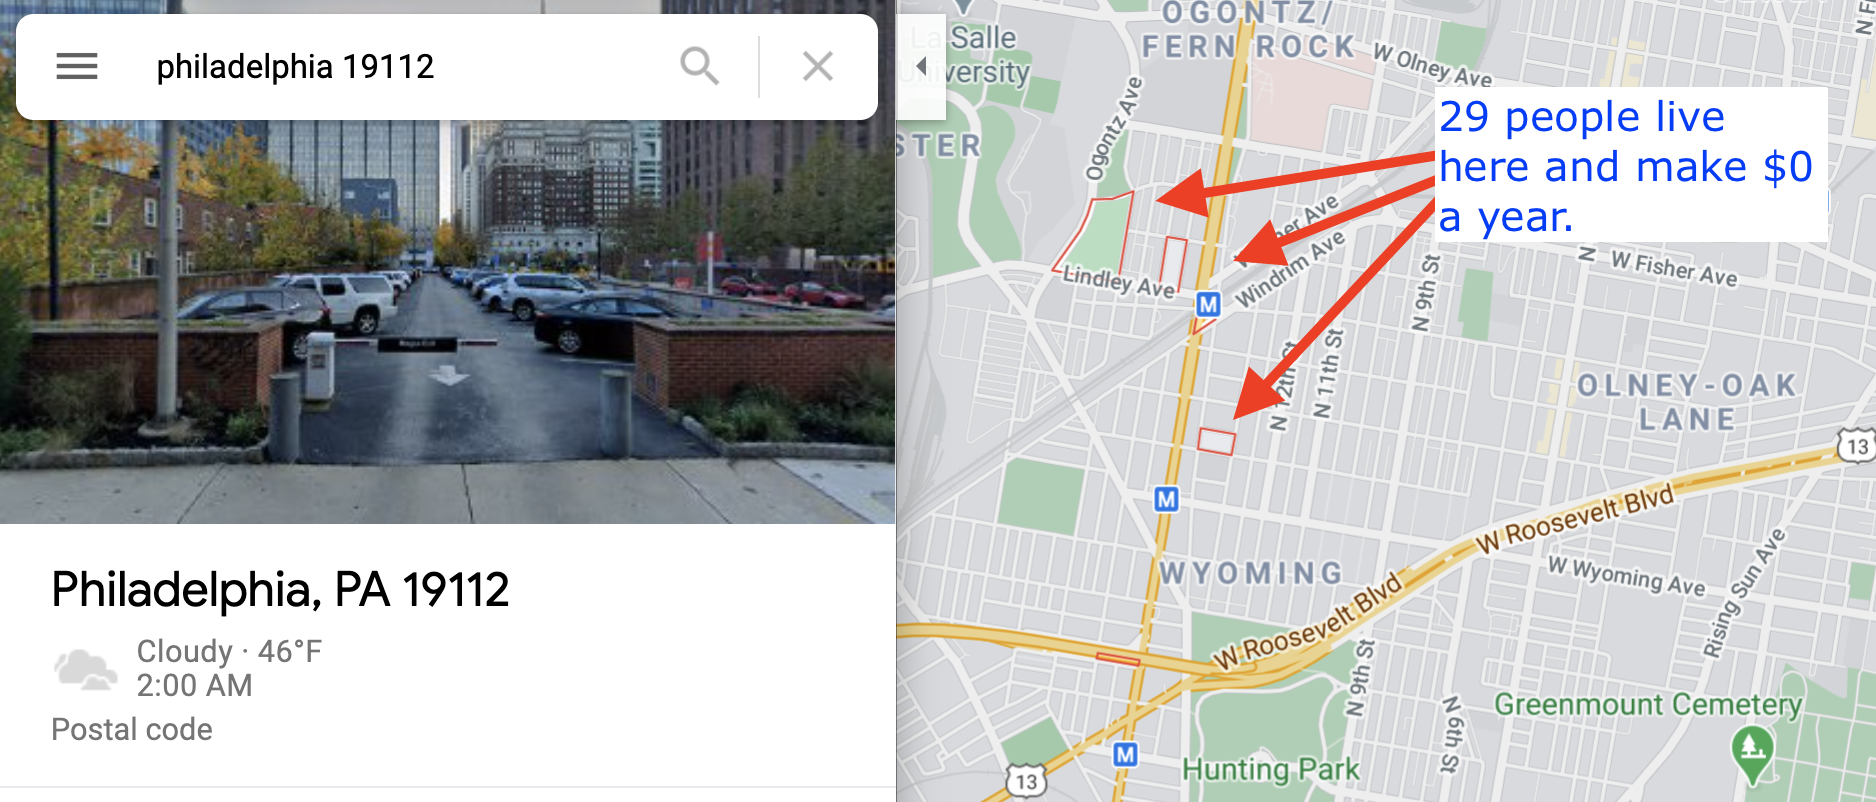

I'm already see discrepencies and outliers in this data. According to a quick Google Maps search, some of these Zip Codes need to deleted and adjusted. The Philadelphia Airport is not a great place, and super small population sizes need to be taken out

In [11]:
income_data.drop([49], inplace=True)
income_data.drop([48], inplace=True)
income_data.drop([1], inplace=True)

This data looks more respectable now. 

In [12]:
print(income_data.shape)
print(philly_data.shape)

(46, 5)
(48, 5)


Uh oh. Now let's match up the data to get rid of the same Zip Codes that we dropped in the income data. 

In [13]:
philly_data.drop([9], inplace=True)
philly_data.drop([40], inplace=True)

In [14]:
print(income_data.shape)
print(philly_data.shape)

(46, 5)
(46, 5)


Now they all match up, great! We got rid of some outliers and data that won't work. We'll do two quick things here. 
- reset the index to zip code so they line up
- join the data together with the Zip Codes.

In [15]:
philly_data.sort_values('Zipcode', inplace=True)
income_data.sort_values('Zipcode', inplace=True)

In [16]:
philly_data['Avg Income'] = income_data['Avg Income']

In [17]:
philly_data.head()

Zipcode               Location                        City Population  \
4   19102  39.953423, -75.165384  Philadelphia, Pennsylvania      4,396   
1   19103  39.952795, -75.173949  Philadelphia, Pennsylvania     19,714   
5   19104  39.960323, -75.197883  Philadelphia, Pennsylvania     50,125   
6   19106  39.950472, -75.147231  Philadelphia, Pennsylvania      8,359   
3   19107  39.951623, -75.158637  Philadelphia, Pennsylvania     12,340   

     Density  Avg Income  
4  22,186.08  $51,949.00  
1  29,353.79         NaN  
5  16,806.34  $46,520.00  
6  12,566.59  $44,776.00  
3  22,723.74  $60,179.00

But now we've got some NaN values in the data. Let's make sure they match up with the data that we were given.

In [18]:
philly_data.loc[(philly_data.Zipcode== '19103') ,'Avg Income'] = '$37,959.00'
philly_data.loc[(philly_data.Zipcode== '19128') ,'Avg Income'] = '$43,629.00'

In [19]:
philly_data.dtypes

Zipcode       object
Location      object
City          object
Population    object
Density       object
Avg Income    object
dtype: object

Let's finalize this Dataframe and move onto some graphs.

In [20]:
philly_data[['Latitude', 'Longitude']] = philly_data.Location.str.split(expand=True)

In [21]:
philly_data.drop('Location', axis=1, inplace=True)
# philly_data.head() 

We'll have to clean up these types and the replace the commas(,), white spaces( ) and dolalr signs($).  Then we'll cast each column as an appropriate type so we can start to plot the data. 

In [22]:
philly_data.Latitude = philly_data.Latitude.str.replace(',', '')
philly_data.Population = philly_data.Population.str.replace(',', '')
philly_data.Density = philly_data.Density.str.replace(',', '')
philly_data['Avg Income'] = philly_data['Avg Income'].str.replace(',', '')
philly_data['Avg Income'] = philly_data['Avg Income'].str.replace('$', '')


philly_data['Avg Income'] = philly_data['Avg Income'].astype(float)
philly_data['Latitude'] = philly_data['Latitude'].astype(float)
philly_data['Longitude'] = philly_data['Longitude'].astype(float)
philly_data['Population'] = philly_data['Population'].astype(int)
philly_data['Density'] = philly_data['Density'].astype(float)
philly_data['Zipcode'] = philly_data['Zipcode'].astype(int)


In [23]:
philly_data.dtypes

Zipcode         int64
City           object
Population      int64
Density       float64
Avg Income    float64
Latitude      float64
Longitude     float64
dtype: object

# 5. Methodolody and Graphing Data
Let's graph some of the data to get a feel for each Zip Code. This will be used in conjuction with the map at the end of this report to help decide where to open up a new Coffe Shop

First, let's take a look at the Zip Codes with the highes incomes.

In [24]:
philly_data.sort_values(by='Avg Income', ascending=False).head()

Zipcode                        City  Population   Density  Avg Income  \
2    19139  Philadelphia, Pennsylvania       43866  24062.66     61720.0   
3    19107  Philadelphia, Pennsylvania       12340  22723.74     60179.0   
4    19102  Philadelphia, Pennsylvania        4396  22186.08     51949.0   
5    19104  Philadelphia, Pennsylvania       50125  16806.34     46520.0   
6    19106  Philadelphia, Pennsylvania        8359  12566.59     44776.0   

    Latitude  Longitude  
2  39.961529 -75.230259  
3  39.951623 -75.158637  
4  39.953423 -75.165384  
5  39.960323 -75.197883  
6  39.950472 -75.147231

Ok, that is some good data that we can use. It appears that the top incomes also have a relatively low density. The top 6 income brackets contain 4 Zip Codes wit less than 13,000 people. That would likely affect the amount of customers coming into the coffee shop on the weekends. 

Let's redo that and look at the Population Totals instead. 

In [25]:
philly_data.sort_values(by='Population', ascending=False).head()

Zipcode                        City  Population   Density  Avg Income  \
13    19143  Philadelphia, Pennsylvania       71169  21569.56     37996.0   
15    19120  Philadelphia, Pennsylvania       68831  21110.03     37760.0   
32    19124  Philadelphia, Pennsylvania       63131  11899.99     27436.0   
10    19111  Philadelphia, Pennsylvania       58874  10679.91     41592.0   
19    19134  Philadelphia, Pennsylvania       57922  17157.59     35650.0   

     Latitude  Longitude  
13  39.942892 -75.225460  
15  40.034147 -75.119198  
32  40.017119 -75.092814  
10  40.063318 -75.077631  
19  39.992219 -75.107863

### Any crossover in these top 10 lists? 
It looks like there are few zip codes that are in both. The ones that stick out to me right now are...
- Zip Code 19139
- Zip Code 19128
- Zip Code 19152
- Zip Code 19111
- Zip Code 19104
- Zip Code 19143 (~38K)
- Zip Code 19120 (~38K)

Let's put some of this data into a graph, and try to remember those Zip Codes

Text(0.5, 1.0, 'Top 20 Average Incomes for Zipcodes')

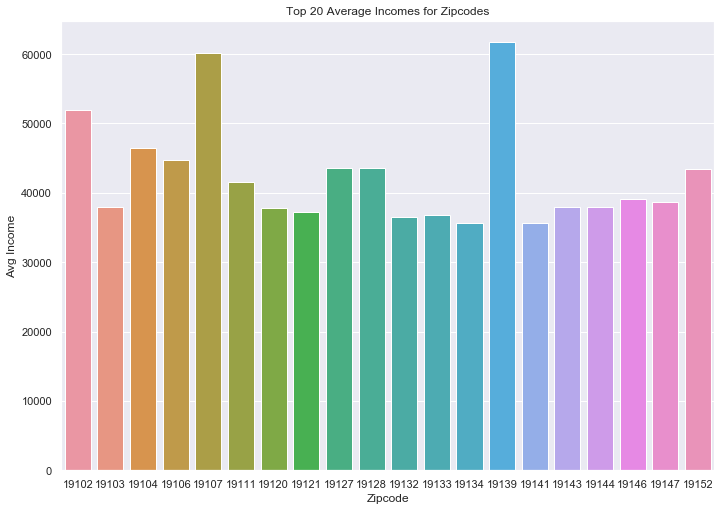

In [26]:
inc = philly_data.sort_values(by='Avg Income', ascending=False)[:20]

sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.barplot(x='Zipcode', y='Avg Income', data=inc)
ax.set_title('Top 20 Average Incomes for Zipcodes')

Text(0.5, 1.0, 'Top 20 Populations for Zipcodes')

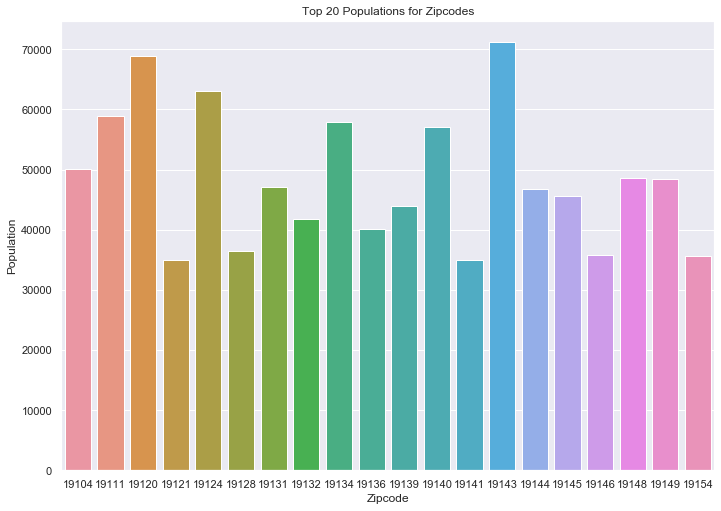

In [27]:
pop = philly_data.sort_values(by='Population', ascending=False)[:20]

sns.set(rc={'figure.figsize':(11.7,8.27)})


ax = sns.barplot(x='Zipcode', y='Population', data=pop)
ax.set_title('Top 20 Populations for Zipcodes')

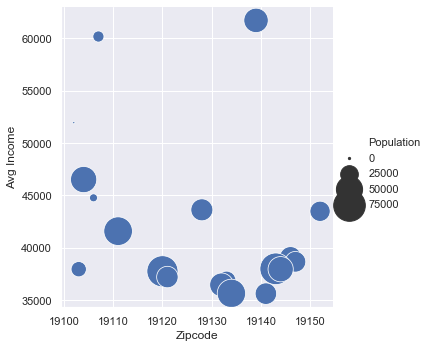

In [28]:
ax = sns.relplot(x="Zipcode", y="Avg Income", size='Population', sizes=(5,1000), data=inc)

sns.set(rc={'figure.figsize':(15.7,8.27)})

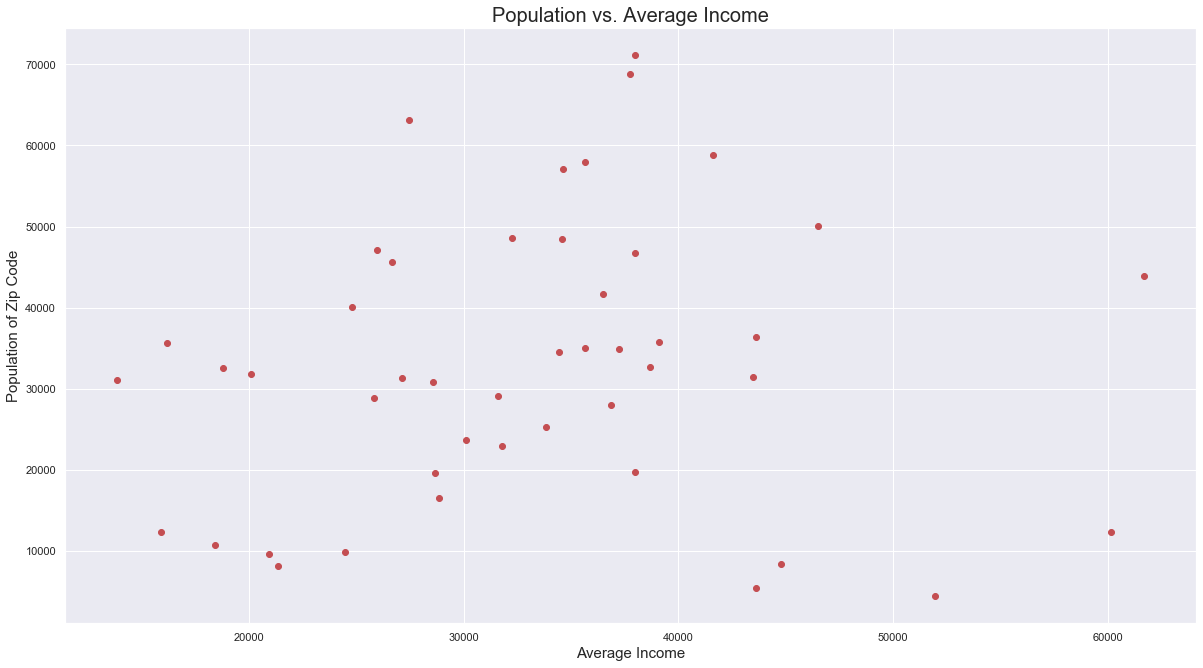

In [29]:
fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(philly_data['Avg Income'], philly_data['Population'], color='r')
ax.set_xlabel('Average Income', size=15)
ax.set_ylabel('Population of Zip Code', size=15)
ax.set_title('Population vs. Average Income', size=20)
plt.show()

### I stil like these Zip Codes
- Zip Code 19139
- Zip Code 19128
- Zip Code 19152
- Zip Code 19111
- Zip Code 19104
- Zip Code 19143
- Zip Code 19120 

# Exploring Venues and Zip Codes

In [30]:
# the below is quite annoying... but it will eventually work 
''' 
address = 'Philadelphia, PA'

geolocator = Nominatim(user_agent="phl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Philadelphia are {}, {}.'.format(latitude, longitude))

'''

' \naddress = \'Philadelphia, PA\'\n\ngeolocator = Nominatim(user_agent="phl_explorer")\nlocation = geolocator.geocode(address)\nlatitude = location.latitude\nlongitude = location.longitude\nprint(\'The geograpical coordinate of Philadelphia are {}, {}.\'.format(latitude, longitude))\n\n'

#### This is often frustrating, so I've saved the values below... 

The geograpical coordinate of Philadelphia are <code> 39.9527237 </code> and <code> -75.1635262 </code>

In [31]:
latitude = 39.9527237
longitude = -75.1635262

# create map of Philly using latitude and longitude values
map_philly = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, zipcode in zip(philly_data['Latitude'], philly_data['Longitude'], philly_data['Zipcode']):
    label = '{}, {}'.format(zipcode, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_philly)  
    
map_philly

In [32]:
CLIENT_ID = '5OMXBU3ZGRZA5BCARJRRJ12VXI4MNWEYKWMRJYM4SOOTUODX' # your Foursquare ID
CLIENT_SECRET = 'TRRWL1N24Z54AUJQZZVJESAZGBVNOD5YSD3HOKMIQLBOXWKQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5OMXBU3ZGRZA5BCARJRRJ12VXI4MNWEYKWMRJYM4SOOTUODX
CLIENT_SECRET:TRRWL1N24Z54AUJQZZVJESAZGBVNOD5YSD3HOKMIQLBOXWKQ


In [33]:
philly_data.loc[1, 'Zipcode']

19103

In [34]:
neighborhood_latitude = philly_data.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = philly_data.loc[10, 'Longitude'] # neighborhood longitude value

neighborhood_name = philly_data.loc[10, 'Zipcode'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 19111 are 40.063318, -75.077631.


Now let's use the Foursquare API and explore the "10th" location. I chose this specific location to provide a larger list of results for us to explore. 
- set the limit of venues to 100
- set the radius to 1000

In [35]:
LIMIT = 100
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)


In [36]:
results = requests.get(url).json()

In [37]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [38]:
from pandas.io.json import json_normalize

In [39]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name         categories        lat        lng
0  Philly Pretzel Factory        Snack Place  40.096406 -74.974329
1              Reens Deli      Deli / Bodega  40.095594 -74.975328
2    Holt's Cigar Company         Smoke Shop  40.102850 -74.985539
3                    Wawa  Convenience Store  40.095763 -74.976109
4                7-Eleven  Convenience Store  40.096123 -74.977298

In [40]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

19 venues were returned by Foursquare.


#### The next part is a function that will help us store the latitude and longitude of each venue into a dataframe for better viewing. 

In [41]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'Zip Latitude', 
                  'Zip Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
philly_venues = getNearbyVenues(names=philly_data['Zipcode'], 
                                  latitudes=philly_data['Latitude'], 
                                  longitudes=philly_data['Longitude'])

19102
19103
19104
19106
19107
19111
19114
19115
19116
19118
19119
19120
19121
19122
19123
19124
19125
19126
19127
19128
19129
19130
19131
19132
19133
19134
19135
19136
19137
19138
19139
19140
19141
19142
19143
19144
19145
19146
19147
19148
19149
19150
19151
19152
19153
19154


In [48]:
print(philly_venues.shape)
philly_venues.head()

(1056, 7)


Zipcode  Zip Latitude  Zip Longitude  \
0    19102     39.953423     -75.165384   
1    19102     39.953423     -75.165384   
2    19102     39.953423     -75.165384   
3    19102     39.953423     -75.165384   
4    19102     39.953423     -75.165384   

                                         Venue  Venue Latitude  \
0                                Dilworth Park       39.952542   
1                   La Colombe Coffee Roasters       39.951659   
2                          City Hall Courtyard       39.952484   
3                        JFK Plaza / Love Park       39.954123   
4  Rothman Institute Ice Rink at Dilworth Park       39.952770   

   Venue Longitude Venue Category  
0       -75.164766           Park  
1       -75.165238    Coffee Shop  
2       -75.163592          Plaza  
3       -75.165303          Plaza  
4       -75.164561   Skating Rink

### How many venues are there in each zipcode?

In [49]:
philly_venues.groupby('Zipcode').count()

Zip Latitude  Zip Longitude  Venue  Venue Latitude  Venue Longitude  \
Zipcode                                                                        
19102             100            100    100             100              100   
19103             100            100    100             100              100   
19104              20             20     20              20               20   
19106              78             78     78              78               78   
19107             100            100    100             100              100   
19111               1              1      1               1                1   
19114               4              4      4               4                4   
19115               2              2      2               2                2   
19116               2              2      2               2                2   
19118               3              3      3               3                3   
19119               9              9      9               9                9   
19120              27             27     27              27               27   
19121               9              9      9               9                9   
19122               9              9      9               9                9   
19123              39             39     39              39               39   
19124              10             10     10              10               10   
19125              33             33     33              33               33   
19126               8              8      8               8                8   
19127              63             63     63              63               63   
19128               5              5      5               5                5   
19129               7              7      7               7                7   
19130              30             30     30              30               30   
19131              11             11     11              11               11   
19132              11             11     11              11               11   
19133              17             17     17              17               17   
19134              19             19     19              19               19   
19135              11             11     11              11               11   
19136              14             14     14              14               14   
19137               9              9      9               9                9   
19138               4              4      4               4                4   
19139               7              7      7               7                7   
19140               7              7      7               7                7   
19141              19             19     19              19               19   
19142               6              6      6               6                6   
19143              11             11     11              11               11   
19144              49             49     49              49               49   
19145               4              4      4               4                4   
19146              17             17     17              17               17   
19147              66             66     66              66               66   
19148              44             44     44              44               44   
19149              25             25     25              25               25   
19150               2              2      2               2                2   
19151               5              5      5               5                5   
19152              16             16     16              16               16   
19153              14             14     14              14               14   
19154               9              9      9               9                9   

         Venue Category  
Zipcode                  
19102               100  
19103               100  
19104                20  
19106                78  
19107       

Well, this list is helpful in that we can see that the following Zip Codes are maxed out in capacity of venues. Probably a hotbed of activity, high rent prices, and Starbucks everywhere. 
- 19102
- 19103
- 19107

Yup, they're all Center City. We'll keep them in mind, but it probably won't be an easy place to succeed for a Boutique Coffee shop. 

### Analyze the Zipcodes

In [50]:
# one hot encoding
philly_onehot = pd.get_dummies(philly_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
philly_onehot['Zipcode'] = philly_venues['Zipcode'] 

# move zipcode column to the first column
fixed_columns = [philly_onehot.columns[-1]] + list(philly_onehot.columns[:-1])
philly_onehot = philly_onehot[fixed_columns]

philly_onehot.head()

Zipcode  Accessories Store  African Restaurant  American Restaurant  \
0    19102                  0                   0                    0   
1    19102                  0                   0                    0   
2    19102                  0                   0                    0   
3    19102                  0                   0                    0   
4    19102                  0                   0                    0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           0                    0                     0   
4            0           0                    0                     0   

   Asian Restaurant  Athletics & Sports  ...  Video Game Store  Video Store  \
0                 0                   0  ...                 0            0   
1                 0                   0  ...                 0            0   
2                 0                   0  ...                 0            0   
3                 0                   0  ...                 0            0   
4                 0                   0  ...                 0            0   

   Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  \
0                      0                0           0         0          0   
1                      0                0           0         0          0   
2                      0                0           0         0          0   
3                      0                0           0         0          0   
4                      0                0           0         0          0   

   Wings Joint  Women's Store  Yoga Studio  
0            0              0            0  
1            0              0            0  
2            0              0            0  
3            0              0            0  
4            0              0            0  

[5 rows x 218 columns]

Examine the new dataframe's shape. 

In [51]:
philly_onehot.shape

(1056, 218)

#### Next, let's group rows by Zip Code and by taking the mean of the frequency of occurrence of each category

In [52]:
philly_grouped = philly_onehot.groupby('Zipcode').mean().reset_index()

#### Confirm the size to make sure. 

In [53]:
philly_grouped.shape

(46, 218)

#### Now we'll get the top 5 venues in each of the zipcodes listed. 

In [54]:
philly_grouped['Zipcode'] = philly_grouped['Zipcode'].astype(str)

In [55]:
num_top_venues = 5

for hood in philly_grouped['Zipcode']:
    print("----Zip "+hood+"----")
    temp = philly_grouped[philly_grouped['Zipcode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Zip 19102----
                venue  freq
0               Hotel  0.10
1         Coffee Shop  0.05
2  Seafood Restaurant  0.04
3      Clothing Store  0.03
4                 Spa  0.03


----Zip 19103----
                 venue  freq
0  American Restaurant  0.07
1                Hotel  0.05
2   Seafood Restaurant  0.05
3          Coffee Shop  0.05
4               Bakery  0.04


----Zip 19104----
                venue  freq
0  Light Rail Station  0.10
1         Pizza Place  0.10
2       Deli / Bodega  0.05
3                 Bar  0.05
4              Office  0.05


----Zip 19106----
                venue  freq
0      History Museum  0.10
1       Historic Site  0.09
2  Italian Restaurant  0.08
3         Coffee Shop  0.05
4               Hotel  0.04


----Zip 19107----
                           venue  freq
0                         Bakery  0.08
1                            Bar  0.04
2                            Pub  0.03
3  Vegetarian / Vegan Restaurant  0.03
4                 Sandwich Pl

### Let's Recale our Favorite Zip Codes so far and have a look for anything that excites us.
- Zip Code 19104 
- Zip Code 19111 (Lots of Coffee shops = see above)
- Zip Code 19120 (~38K)
- Zip Code 19128
- Zip Code 19139
- Zip Code 19143 (~38K)
- Zip Code 19152

Most of these Zip Codes look okay, but we'll have to get rid of 19111 since 100% of the shops from the Foursquare API are Coffee Shops. This won't be an easy place to open a new one. 

#### Put this data into a _pandas_ dataframe
First, let's write a function to sort the venues in descending order.


In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each Zipcode.

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zipcode'] = philly_grouped['Zipcode']

for ind in np.arange(philly_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(philly_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Zipcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0   19102                 Hotel           Coffee Shop    Seafood Restaurant   
1   19103   American Restaurant                 Hotel           Coffee Shop   
2   19104    Light Rail Station           Pizza Place      Toy / Game Store   
3   19106        History Museum         Historic Site    Italian Restaurant   
4   19107                Bakery                   Bar                 Hotel   

           4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                    Yoga Studio                Bakery   American Restaurant   
1             Seafood Restaurant                Bakery         Deli / Bodega   
2                     Food Truck         Deli / Bodega                Office   
3                    Coffee Shop                 Hotel                   Bar   
4  Vegetarian / Vegan Restaurant                   Pub        Sandwich Place   

      7th Most Common Venue    8th Most Common Venue  \
0            Clothing Store                      Spa   
1               Yoga Studio  New American Restaurant   
2       Szechuan Restaurant                   Lounge   
3            Ice Cream Shop                Gastropub   
4  Mediterranean Restaurant       Mexican Restaurant   

      9th Most Common Venue 10th Most Common Venue  
0  Mediterranean Restaurant         Sandwich Place  
1             Women's Store                    Bar  
2               Beer Garden            Coffee Shop  
3                      Café               Boutique  
4             Deli / Bodega      Convenience Store

## Cluster the Neighborhoods/Zipcodes

Run a k-means to cluster the Zipcodes into 5 clusters.

In [58]:
# set number of clusters
kclusters = 5

philly_grouped_clustering = philly_grouped.drop('Zipcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(philly_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 4, 1, 2, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood/zipcode.

In [59]:
print(neighborhoods_venues_sorted['Zipcode'].dtypes)
print(philly_data['Zipcode'].dtypes)

object
int64


#### Let's make sure the Zip Code types are both int64 before we join them together. 

In [60]:
philly_data['Zipcode'] = philly_data['Zipcode'].astype(int)
neighborhoods_venues_sorted['Zipcode'] = neighborhoods_venues_sorted['Zipcode'].astype(int)

In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [62]:
philly_merged = philly_data

# merge philly_grouped with philly_data to add latitude/longitude for each neighborhood
philly_merged = philly_merged.join(neighborhoods_venues_sorted.set_index('Zipcode'), on='Zipcode')

philly_merged.head()

Zipcode                        City  Population   Density  Avg Income  \
4    19102  Philadelphia, Pennsylvania        4396  22186.08     51949.0   
1    19103  Philadelphia, Pennsylvania       19714  29353.79     37959.0   
5    19104  Philadelphia, Pennsylvania       50125  16806.34     46520.0   
6    19106  Philadelphia, Pennsylvania        8359  12566.59     44776.0   
3    19107  Philadelphia, Pennsylvania       12340  22723.74     60179.0   

    Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
4  39.953423 -75.165384               1                 Hotel   
1  39.952795 -75.173949               1   American Restaurant   
5  39.960323 -75.197883               1    Light Rail Station   
6  39.950472 -75.147231               1        History Museum   
3  39.951623 -75.158637               1                Bakery   

  2nd Most Common Venue 3rd Most Common Venue          4th Most Common Venue  \
4           Coffee Shop    Seafood Restaurant                    Yoga Studio   
1                 Hotel           Coffee Shop             Seafood Restaurant   
5           Pizza Place      Toy / Game Store                     Food Truck   
6         Historic Site    Italian Restaurant                    Coffee Shop   
3                   Bar                 Hotel  Vegetarian / Vegan Restaurant   

  5th Most Common Venue 6th Most Common Venue     7th Most Common Venue  \
4                Bakery   American Restaurant            Clothing Store   
1                Bakery         Deli / Bodega               Yoga Studio   
5         Deli / Bodega                Office       Szechuan Restaurant   
6                 Hotel                   Bar            Ice Cream Shop   
3                   Pub        Sandwich Place  Mediterranean Restaurant   

     8th Most Common Venue     9th Most Common Venue 10th Most Common Venue  
4                      Spa  Mediterranean Restaurant         Sandwich Place  
1  New American Restaurant             Women's Store                    Bar  
5                   Lounge               Beer Garden            Coffee Shop  
6                Gastropub                      Café               Boutique  
3       Mexican Restaurant             Deli / Bodega      Convenience Store

## Let's visualize what we just did there, and put it on a map. 

In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(philly_merged['Latitude'], philly_merged['Longitude'], philly_merged['Zipcode'], philly_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 6. Results - Examine the Zip Codes we Liked

- Zip Code 19104 
- Zip Code 19120 (~38K)
- Zip Code 19128
- Zip Code 19139
- Zip Code 19143 (~38K)
- Zip Code 19152

In [64]:
philly_merged.set_index('Zipcode', inplace=True)
philly_merged.drop(['City', 'Latitude', 'Longitude', 'Cluster Labels'], axis=1, inplace=True)

In [65]:
philly_merged.loc[[19104, 19120, 19128, 19139, 19143, 19152]]

Population   Density  Avg Income 1st Most Common Venue  \
Zipcode                                                           
19104         50125  16806.34     46520.0    Light Rail Station   
19120         68831  21110.03     37760.0          Intersection   
19128         36420   5163.86     43629.0            Public Art   
19139         43866  24062.66     61720.0        Breakfast Spot   
19143         71169  21569.56     37996.0          Intersection   
19152         31379  10538.35     43490.0           Pizza Place   

        2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
Zipcode                                                                     
19104             Pizza Place      Toy / Game Store            Food Truck   
19120           Women's Store    Seafood Restaurant                  Bank   
19128       Convenience Store           Flower Shop           Beer Garden   
19139                Pharmacy                  Food  Caribbean Restaurant   
19143      Chinese Restaurant   American Restaurant          Dessert Shop   
19152                Pharmacy          Intersection            Restaurant   

        5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
Zipcode                                                                     
19104           Deli / Bodega                Office   Szechuan Restaurant   
19120       Mobile Phone Shop        Shopping Plaza  Fast Food Restaurant   
19128                     Gym           Yoga Studio     Electronics Store   
19139           Grocery Store                Lounge         Deli / Bodega   
19143       Convenience Store                  Park                Market   
19152             Supermarket    Seafood Restaurant   Martial Arts School   

        8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
Zipcode                                                                     
19104                  Lounge           Beer Garden            Coffee Shop  
19120                Pharmacy        Sandwich Place     Chinese Restaurant  
19128              Food Court     Food & Drink Shop                   Food  
19139          Discount Store              Dive Bar             Food Court  
19143           Metro Station              Pharmacy     Falafel Restaurant  
19152            Liquor Store                   Bar         Baseball Field

### Here is a nice list of the Zip Codes that I think will be a suitable place for us to open a new Coffee Shop.

# 7. Discussion

From the research and data, I wanted to make sure that the place in Philadelphia that we were choosing was in the upper range of the Average Income and the upper range of the Population. From there, I plotted multiple graphs to see if there were any other outliers that may be a good choice. There were a few, but these were all located in the Center City of Philadelphia. This would be a great place, but the cost of upkeep, rent, and competition from other big name brands would be very difficult. Building a reputation in Philadelphia first should be priority number one. If this shop works out, then the high cost in Center City may be a good gamble. It wasn't the focus here. 

There are not a lot of coffee shops that were found with the Foursquare API in Philadelphia. Most were concentrated in Center City, but a lot of opportunity lay outside of that area. I narrowed down the selection to 6 Zip Codes above. 

Most of the areas are very similar with the exceptions of <code> 19128 </code> and <code> 19152 </code>. These areas have a much lower population density (half as low) as the other possible Zip Code locations. This may be something to discuss in a meeting with the CEO and owner. Ultimately, he will make the decision where to go. I am very satisfied that there will be zero, or close to zero, competing Coffee Shops in any of these locations. I am confident that with this data the CEO can make a more informed decision. 

* As a final note, I purposely left out the Neighborhood names in this data, because it may have been an influencing factor

# 8. Conclusion 

I would recommend Zip Code <code> 19139 </code> because it has the highest density and highest income of all of the candidates locations. With this being said, there should be sufficient income for people to spend time on the weekend to enjoy a coffee at a new coffee shop, or grab a coffee before heading to work. 

Notably, there is a metro station that would provide a great opportunity to people to get their morning coffee before getting the metro and heading to work. 

I hope with this information my friend and CEO can make a great decision to expand his business. 